Today we will work with neural networks! We will start with simple models that you have seen in the lecture: the perceptron and the multilayer perceptron (MLP).

## Perceptron
The implementation of the perceptron algorithm is simple - the parameters consist of just one vector, and the adaptation rule is  straightforward. We will design the interface of the perceptron to have the same API as models in scikit-learn - i.e., parameters will be set in the constructor, and the class will have two methods - `fit(X, y)` and `predict(X)`.

We will use the matrix notation - the weighted sum will be calculated as a dot product. This (along with numpy) will simplify the implementation and speed up the algorithm.

In [2]:
import numpy as np

class Perceptron:
    
    def __init__(self, lr, max_iter=100):
        self.lr = lr  # learning rate
        self.max_iter = max_iter
        
    def fit(self, train_X, train_y):
        train_x = np.array(train_X)
        train_x = self._add_ones(train_x)
        self.w_ = np.zeros(train_x.shape[1])
        
        for _ in range(self.max_iter):
            for x,y in zip(train_x, train_y):
                y_hat = self.predict(x, add_ones=False)  # ones were already added before
                self.w_ = self.w_ + self.lr * (y - y_hat) * x
        
    def predict(self, X, add_ones=True):
        x = np.array(X)
        if add_ones:
            x = self._add_ones(x)
        
        return (np.sign(np.dot(x, self.w_.T)) + 1) / 2 # sign -1 or 1 -> change to 0 or 1
    
    def _add_ones(self, x): # add a column of 1s instead of bias
        ones = np.ones(shape=(x.shape[0],1))
        x = np.append(ones,x, axis=1)        
        return x

We will **randomly generate data** for testing the class. To do that, we will use simple generators from scikit-learn. We will generate data that belong to 2 classes. Note that results differ based on whether the classes are linearly separable.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# simple method to visualize the decision boundary of the model, later we will also use it for one-hot encoding
def draw_boundary(model, X, y, one_hot=False):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    if one_hot:
        Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(12,8))
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.show()

In [10]:
x, y = np.meshgrid([1,2,3], [3,4,5])  # generates a grid ... cartesian product
print(x.ravel())  # ravel is like flatten, but does not copy the data (only a "view")
print(y.ravel())
np.c_[x.ravel(), y.ravel()]  # c_ is concat

[1 2 3 1 2 3 1 2 3]
[3 3 3 4 4 4 5 5 5]


array([[1, 3],
       [2, 3],
       [3, 3],
       [1, 4],
       [2, 4],
       [3, 4],
       [1, 5],
       [2, 5],
       [3, 5]])

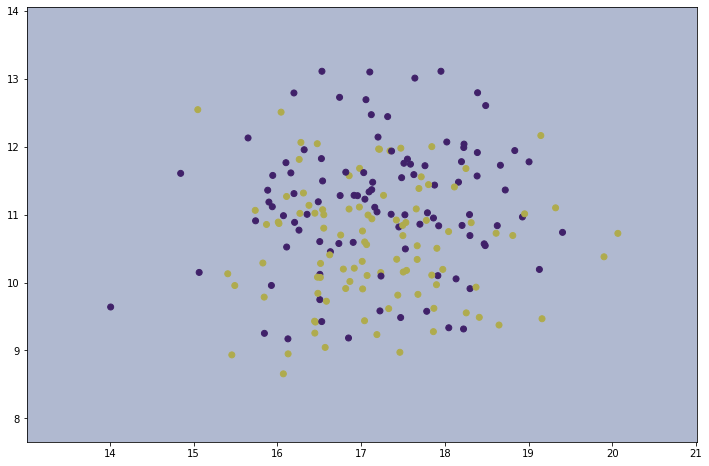

In [22]:
from sklearn import datasets

# try running this cell multiple times to see the difference between separable vs non-separable data 
X, y = datasets.make_blobs(centers=2, n_samples=200)

X += (10,10)

perc = Perceptron(0.1, 1000)
perc.fit(X, y)
draw_boundary(perc, X, y)

# Multi-layered perceptron

It is ~~similarly easy~~ easy (if you slept well) to implement MLP. The tricky part is to fully understand the weight update equations, [see the lecture notes](https://ktiml.mff.cuni.cz/~pilat/en/nature-inspired-algorithms/neural-networks-introduction/). We will use numpy and matrix notation again.

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(x))


def sigmoid_derivative(x):
    return x * (1 - x)


class MLP:
    
    def __init__(self, layer_sizes, alpha=0.01, ngen=1):
        self.layer_sizes = layer_sizes
        self.layers = []
        self.alpha = alpha
        self.ngen = ngen
        
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            self.layers.append(np.random.normal(size=(p+1, n)))
            #self.weights.append(np.random.normal(size=(p, n)))
            #self.bias.append(np.random.normal(size=(p,)))
        
    def predict(self, X, as_pb=False):
        activations = np.array(X)
        try:
            for layer in self.layers:
                activations_1 = self._add_ones(activations) # add 1 for bias
                activations = sigmoid(np.dot(activations_1, layer))
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations if as_pb else (activations > 0.5).astype(int)
    
    def fit(self, X, y):
        # implement yourselves
    #for xx, yy in zip(X, y):
        #xx = xx[np.newaxis]  # (4,) -> (1, 4)
        #yy = np.array([yy])

        xx = X
        yy = y[:, np.newaxis]
        
        # forward pass
        activations = [xx]  # y_j
        act = xx

        for layer in self.layers:
            act = self._add_ones(act)
            act = sigmoid(np.dot(act, layer))
            activations.append(act)

        deltas = []
        # backprop - deltas
        for i, act in enumerate(reversed(activations)):
            if i == len(self.layers):
                break

            if i == 0:
                # output layer
                #print(act.shape)
                delta = (yy - act) * sigmoid_derivative(act)
            else:
                delta = np.dot(deltas[-1], self.layers[-i].T[:, 1:]) * sigmoid_derivative(act)

            deltas.append(delta)

        # backprop - update
        for i, (delta, act) in enumerate(zip(reversed(deltas), activations)):
            if i == len(self.layers):
                break

            grad = np.dot(act.T, delta)
            grad = np.append(np.sum(delta, axis=0)[np.newaxis], grad, axis=0)

            self.layers[i] -= self.alpha * grad
        
        return self
        
        
    def _add_ones(self, x): # add a column of ones instead of bias
        ones = np.ones(shape=(x.shape[0],1))
        x = np.append(ones,x, axis=1)
        return x

In [31]:
a = [1,2,3,4]
list(zip(a[::2], a[1::2]))

[(1, 2), (3, 4)]

In [32]:
mlp = MLP([2,10,5,1])

mlp.predict(np.array([[2,3], [2,7], [3, 4]]))

array([[0],
       [0],
       [0]])

In [33]:
[l.shape for l in mlp.layers]

[(3, 10), (11, 5), (6, 1)]

In [43]:
X, y = datasets.make_blobs(centers=2, n_samples=200)

X += (10,10)

for _ in range(10):
    mlp.fit(X,y)

In [44]:
for _ in range(10):
    mlp.fit(X,y)

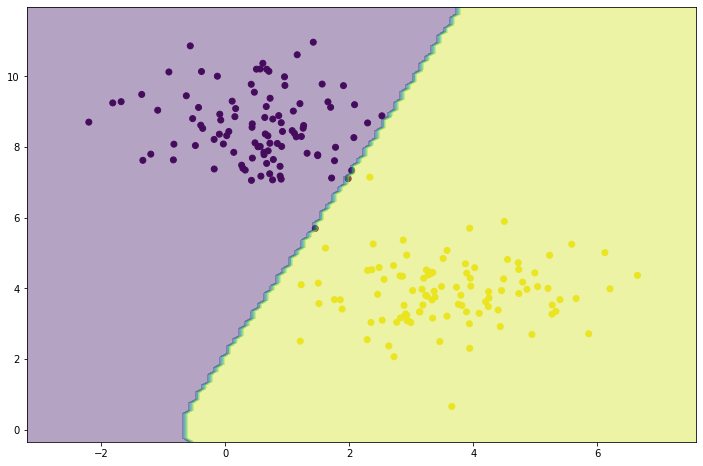

In [45]:
draw_boundary(mlp, X, y)

# Quick intro to tensorflow
Nowadays neural networks are primarily written using libraries such as tensorflow, PyTorch, or JAX. Today, we will demonstrate how to use keras (part of TensorFlow but also compatible with other frameworks) to implement a neural network.

In [46]:
# prepare the data

x, y = datasets.make_blobs(n_samples=300, centers=3)

x_train, x_test = x[:250], x[250:]
y_train, y_test = y[:250], y[250:]

import tensorflow as tf

# set the network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
    ]
)

# set the optimization
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the network
model.fit(x_train, y_train, epochs=200, verbose=0)
# predict some of the instances
model.predict(x_test[:10])

2024-04-09 12:10:13.455158: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 12:10:13.523708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-09 12:10:13.523724: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-09 12:10:16.811327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-09 12:10:16.811376: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to c

1/1 [==============================] - 0s 50ms/step


array([[0.8666283 , 0.09150349, 0.04186817],
       [0.8573887 , 0.0998145 , 0.04279677],
       [0.8147181 , 0.13985775, 0.0454241 ],
       [0.9102372 , 0.05300604, 0.03675673],
       [0.10439333, 0.8719859 , 0.02362083],
       [0.08384922, 0.8897602 , 0.02639047],
       [0.02392208, 0.07816306, 0.8979149 ],
       [0.10177994, 0.875607  , 0.02261304],
       [0.8965742 , 0.06490144, 0.03852433],
       [0.87084293, 0.08775464, 0.04140243]], dtype=float32)

1333/1333 [==============================] - 1s 983us/step


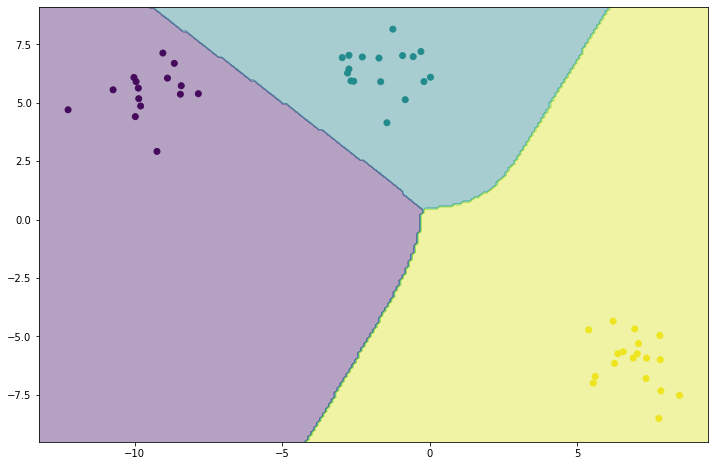

In [47]:
draw_boundary(model, x_test, y_test, one_hot=True)

## PyTorch

In [318]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn import datasets
from torch.utils.data import TensorDataset, DataLoader

# prepare the data
x, y = datasets.make_blobs(n_samples=300, centers=3)
x_train, x_test = torch.tensor(x[:250]).float(), torch.tensor(x[250:]).float()
y_train, y_test = torch.tensor(y[:250]), torch.tensor(y[250:])

# Create DataLoader for batching
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# set the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 3)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        
        x = torch.sigmoid(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x
    
    def predict(self, x):
        return self.forward(x).detach()

model = Net()

# set the optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# train the network
for epoch in range(200):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

# predict some of the instances
with torch.no_grad():
    predictions = model(x_test[:10])
    print(predictions)

tensor([[0.1147, 0.2747, 0.6106],
        [0.1739, 0.2892, 0.5370],
        [0.1255, 0.2821, 0.5924],
        [0.8484, 0.0855, 0.0661],
        [0.1546, 0.2876, 0.5578],
        [0.8367, 0.0896, 0.0737],
        [0.8478, 0.0856, 0.0666],
        [0.1164, 0.2775, 0.6061],
        [0.1373, 0.2786, 0.5840],
        [0.1206, 0.2799, 0.5995]])


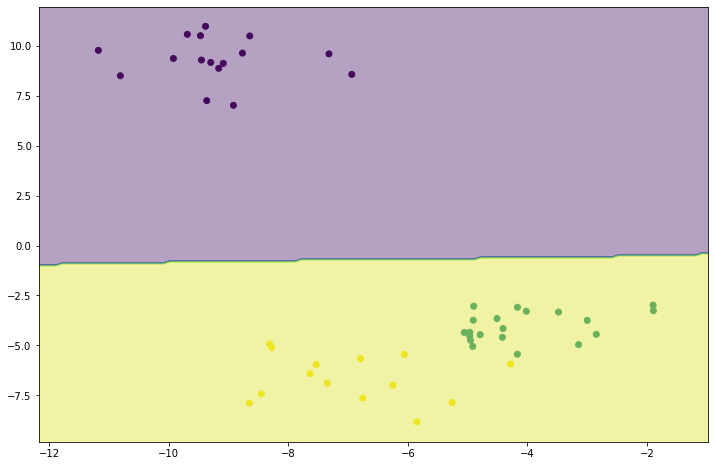

In [319]:
draw_boundary(model, x_test, y_test, one_hot=True)

## Prehistorie

In most cases, you'll probably use tensorflow at a similar level to above, i.e. you'll be creating models from existing modules. But let's quickly look a little deeper at how tensorflow works.

Tensorflow is really a library for symbolic computation. In it, we can define a computation (expression) that we will evaluate later. From a neural network point of view, it is important that tensorflow can also compute the gradient from this expression, and it also contains a number of optimizers.

There are three main types of "variables" in tensorflow - Placeholder is used for inputs to the expression (when we want to evaluate it later, we have to give them a value), Constant is used for constants, and Variable is used for variables that can possibly be trained. An example of creating a simple expression that computes a linear model of type 
 is below. Note that 
 is a placeholder and doesn't get a value until later. In addition, we also compute the MSE based on 
, so we have a ready-made model for linear regression that can learn to predict 
 based on 
.

The examples below use the old tensorflow v1 interface that had a number of low-level functions. Some of these were (re)moved in tensorflow 2. These are the functions starting with tf.compat.v1

In [320]:
import pprint
# create training data and print them
x_train = np.random.uniform(0, 1, size=(100, 3))
y_train = np.dot(x_train, np.array([2,3,1])) + 1
pprint.pprint(list(zip(x_train, y_train))[:10])

[(array([0.25833362, 0.16819167, 0.26081394]), 2.2820561908701644),
 (array([0.84637658, 0.13980661, 0.0771753 ]), 3.1893482800774304),
 (array([0.81790313, 0.28508562, 0.97033847]), 4.46140160037031),
 (array([0.65151374, 0.84488403, 0.69719358]), 5.53487314901821),
 (array([0.28511274, 0.88234389, 0.69004303]), 4.9073001715247075),
 (array([0.96941385, 0.41066377, 0.24547773]), 4.416296727330835),
 (array([0.44147952, 0.63399525, 0.68569174]), 4.470636548310546),
 (array([0.76061234, 0.81582199, 0.58741587]), 5.556106515296722),
 (array([0.20632539, 0.65585086, 0.67876164]), 4.058965005593745),
 (array([0.16546588, 0.05547061, 0.20324935]), 1.7005929246378988)]


In [478]:
# remove the previous model
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

# define the model inputs
# None in shape means that this dimension will be defined later - typically it is used for the training/testing data,
# where we do not know how many instance we will get, only one dimension can be None
x = tf.compat.v1.placeholder(tf.float32, shape=(None, 3))
y = tf.compat.v1.placeholder(tf.float32, shape=(None,))

# define the trainable variables, we need to specify initial values for them
w = tf.Variable(tf.compat.v1.random_uniform(shape=(3,)))
b = tf.Variable(tf.compat.v1.random_uniform(shape=(1,)))
# and we can use the variables to define the output of the model
z = tf.tensordot(x, w, 1) + b

# define the loss function
loss = tf.reduce_mean(tf.compat.v1.squared_difference(z, y))

# before we can evaluate the model, we must set the variables initializer
init = tf.compat.v1.global_variables_initializer()

# if we want to train the model, we need to set up the optimizer - it will use the loss function defined above

optim = tf.compat.v1.train.GradientDescentOptimizer(0.1).minimize(loss)

# tensorflow can also compute gradients
grad = tf.gradients(loss, xs=[w,b])    

# all computations in tensorflow run in a Session
with tf.compat.v1.Session() as sess:
    # if we want to evaluate something, we use Session.run()
    sess.run(init)  # initialize the variables
    
    # we can print the values of the variables (we need to call run to compute the values)
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    # we can specify the values of placeholders with feed-dict
    print('z:', sess.run(z, feed_dict={x: [[1,1,1]]}))
    
    print('loss:', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    # tensorflow can compute the gradients
    wg,bg = sess.run(grad, feed_dict={x: x_train, y:y_train})
    print('wg:', wg)
    print('bg:', bg)
    # one call to optim runs one step of gradient descend
    for k in range(10):
        for i in range(100):
            sess.run(optim, feed_dict={x: x_train, y:y_train})
        print(f'epoch {100*(k+1)}: loss ', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    # we can also print the values to check the result
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    
    # we can also implement the optimization manually using the gradient descend algorithm
    print('='*50)
    
    sess.run(init)
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    
    # let us define the operations from the gradient descend algorithm, we need to define them outside of the loop,
    # otherwise they would be added to the computation loop mutliple times and slow the computation down considerably
    # NOT THIS: sess.run([w.assign_sub(0.1*wg), b.assign_sub(0.1*bg)], feed_dict={x: x_train, y:y_train})
    wg, bg = grad
    w_update=w.assign_sub(0.1*wg)
    b_update=b.assign_sub(0.1*bg)
    
    for k in range(10):
        for i in range(100):
            # session.run can evaluate mutliple expressions at the same time
            sess.run([w_update, b_update], feed_dict={x: x_train, y:y_train})
        print(f'epoch {100*(k+1)}: loss ', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    
    # let't print the values of the parameters again
    w_, b_ = sess.run([w,b])
    print('w:', w_)
    print('b:', b_)

w: [0.50769186 0.27478802 0.57420015]
b: [0.34215343]
z: [1.6988335]
loss: 9.918565
wg: [-3.3024445 -3.5148163 -3.176413 ]
bg: [-6.0465913]
epoch 100: loss  0.024413984
epoch 200: loss  0.0038171648
epoch 300: loss  0.000689273
epoch 400: loss  0.00012664146
epoch 500: loss  2.3337263e-05
epoch 600: loss  4.3033606e-06
epoch 700: loss  7.9386996e-07
epoch 800: loss  1.4648374e-07
epoch 900: loss  2.7043916e-08
epoch 1000: loss  5.0175237e-09
w: [1.9998548 2.999839  0.9998682]
b: [1.0002344]
w: [0.34560132 0.01568472 0.22930336]
b: [0.41676784]
epoch 100: loss  0.034172278
epoch 200: loss  0.005700025
epoch 300: loss  0.0010401972
epoch 400: loss  0.00019156787
epoch 500: loss  3.5324094e-05
epoch 600: loss  6.5144804e-06
epoch 700: loss  1.2016063e-06
epoch 800: loss  2.2159372e-07
epoch 900: loss  4.0908972e-08
epoch 1000: loss  7.571952e-09
w: [1.9998219 2.999802  0.9998379]
b: [1.0002879]
